In [2]:
import numpy as np
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u


# In[6]:


def cyl_coVolume(_RADIUS, _ZMIN, _ZMAX, cosmology):
    """
    echo
    echo  cyl_coVolume:
    echo
    echo   Estimate the comoving volume of a cylinder with basis pi*R^2 
    echo   (where R="$1" radius of the basis in arcsec) and an high defined 
    echo   by the redshift boundaries "$2" and "$3".
    echo   The result is stored in the variable cyl_coVolume and is in
    echo   comoving Mpc^3.
    echo   The macro uses eq. 28 in Hogg (2000). The comoving volume is: 
    echo   dVc= D_H (1+z)^2 D_A^2 dOmega dz / E(z)
    echo   where:
    echo   - D_H	Hubble distance 
    echo   - D_A	Angular Diameter distance
    echo   - dOmega Solid angle
    echo   - dz	Redshift interval
    echo   - E(z) = sqrt( OMEGA_M*(1+z)^3 + OMEGA_K*(1+z)^2 + OMEGA_L )
    echo   
    echo   EXAMPLE:
    echo   cyl_coVolume RADIUS Z_MIN Z_MAX   
    echo
    """
    _BASIS=np.pi*_RADIUS**2. # basis in arcsec^2
    return  coVolume(_BASIS, _ZMIN, _ZMAX, cosmology)


def coVolume(_BASIS, _ZMIN, _ZMAX, cosmology):
    """
    echo
    echo  coVolume:
    echo
    echo   Estimate the comoving volume with basis "$1" (in arcsec^2) 
    echo   and an high define by the redshift boundaries "$2" and "$3".
    echo   The result is stored in the variable coVolume and is in
    echo   comoving Mpc^3.
    echo   The macro uses eq. 28 in Hogg (2000). The comoving volume is: 
    echo   dVc= D_H (1+z)^2 D_A^2 dOmega dz / E(z)
    echo   where:
    echo   - D_H	Hubble distance 
    echo   - D_A	Angular Diameter distance
    echo   - dOmega Solid angle
    echo   - dz	Redshift interval
    echo   - E(z) = sqrt( OMEGA_M*(1+z)^3 + OMEGA_K*(1+z)^2 + OMEGA_L )
    echo   
    echo   EXAMPLE:
    echo   coVolume BASIS Z_MIN Z_MAX   
    echo
    """

    # Calculate the volume

    # Using eq. 28 in Hogg (2000) the comoving volume is: 
    # dVc= D_H (1+z)^2 D_A^2 dOmega dz / E(z)
    # where:
    # - D_H    Hubble distance 
    # - D_A    Angular Diameter distance
    # - dOmega Solid angle
    # - dz     Redshift interval
    # - E(z) = sqrt( OMEGA_M*(1+z)^3 + OMEGA_K*(1+z)^2 + OMEGA_L )

    # D_H: is given by the macro: define_cosmo

    # _ZBIN: Define the bin in redshift over which you want to integrate
    _ZBIN=0.00001
    # _ZINT: Define the redshift range over which integrate
    _ZINT = np.arange(_ZMIN, _ZMAX, _ZBIN)
    _D_A = 1./(1000.*cosmology.arcsec_per_kpc_proper(redshift).value) # Mpc / arcsec

    # _dOmega is the basis in arcsec^2

    # _E_z

    # The element of volume is thus:
    _dVc = cosmology.hubble_distance.to('Mpc').value * (1.+_ZINT)**2. * _D_A**2. * _BASIS * _ZBIN / cosmology.efunc(_ZINT)

    return np.nansum(_dVc)



def dv2dz(DELTA_V, redshift):
    """# Convert velocity difference into redshift difference
    # $1 is DELTA_V in km/s
    # $2 is the redshift where to convert DELTA_V
    """
    return DELTA_V * (1. + redshift) / 299792.458


def WP_QSO(_Rzero, _Gamma, _ZZ, _Vmax, _Rmin, _Rmax, cosmology):
    """Estimate Wp from the 2pcf using the Hennawi+06 formalism
    
    Args:
    _Rzero $1 # Correlation length in cMpc
    _Gamma $2 # gamma
    _ZZ    $3 # redshift where estimate 2pcf
    _Vmax  $4 # maximum velocity difference
    _Rmin =   $5 # Minimum Radius of the shell in cMpc
    _Rmax =   $6 # Maximum Radius of the shell in cMpc
    cosmology
    
    echo
    echo  WP_QSO 6
    echo
    echo   Estimate Wp from the 2pcf using the Hennawi et al. (2006)
    echo   formalism (see Eq. 11).
    echo   The expexted number of objects within a certain shell (including
    echo   clusterin) will be:
    echo   N = density * Vshell * ( 1 + Wp ).
    echo   The macro want in input: 
    echo    - "$1" Correlation length in cMpc
    echo    - "$2" Gamma
    echo    - "$3" Redshift where estimate 2pcf
    echo    - "$4" Maximum velocity difference in km/s
    echo           the shell will be 2x"$4" tall
    echo    - "$5" Minimum Radius of the shell in cMpc
    echo    - "$6" Maximum Radius of the shell in cMpc
    echo   The result is in the vector WP_QSO.
    echo
    echo   EXAMPLE:
    echo   WP_QSO R_zero GAMMA REDSHIFT VELOCITY R_min R_max
    echo
    
    """
    # Estimate the limit of the integral in dPI
    _PImin= ( -1*_Vmax*(1.+_ZZ)/(cosmology.H0.value*cosmology.efunc(_ZZ))) # cMpc
    _PImax= ( +1*_Vmax*(1.+_ZZ)/(cosmology.H0.value*cosmology.efunc(_ZZ))) # cMpc

    # Estimate shell volume
    _Vshell = np.pi*( (_Rmax**2.)-(_Rmin**2.) ) * ( 2.*_Vmax*(1.+_ZZ)/(cosmology.H0.value*cosmology.efunc(_ZZ)) ) # cMpc^3
    
    # Calculate the two integral

    _intTEMP = np.zeros_like(_Rmin)

    _PI= np.arange(_PImin,_PImax,(_PImax-_PImin)/1000.) # 1000. integration step
    _dPI=(_PImax-_PImin)/1000.
    for _iii in range(len(_Rmin)):
        _RR=np.arange(_Rmin[_iii],_Rmax[_iii],(_Rmax[_iii]-_Rmin[_iii])/1000.) # 1000. integration step
        _dRR=((_Rmax[_iii]-_Rmin[_iii])/1000.)
        _intPI=np.zeros_like(_RR)
        for _jjj in range(len(_RR)):
            _intPI[_jjj] = np.nansum( _dPI * ( (1.+(_PI/_RR[_jjj])**2.)**(-1.*_Gamma/2.) ) )
        _intRR = np.nansum( _dRR * ( 2.*np.pi*_RR * ( (_RR/_Rzero)**(-1.*_Gamma) ) * _intPI ) )
        _intTEMP[_iii] = _intRR
    return _intTEMP/_Vshell, _Vshell


def integral_lf_lae(lum_lya_min, lum_lya_max):
    """Integrate the LAE luminosity function between lum_lya_min and lum_lya_max.
    """
    # Integrate the z~6.6 LAEs LF from Konno et al. (2017)
    # Define LF parameters:
    # PHI(L)dL = PHI* * (L/L*)**ALPHA * exp(-L/L*) d(L/L*)
    # From Table 4 of Konno et al. (2017):
    _LFALPHA       = -2.49
    _LFPHISTAR     = ((0.467      )*1E-1)
    _LFPHISTAR_lo  = ((0.467-0.442)*1E-1)
    _LFPHISTAR_up  = ((0.467+1.440)*1E-1)
    _LFLSTAR       = (16.6     ) # 1E42 erg/s
    _LFLSTAR_lo    = (16.6-0.69) # 1E42 erg/s
    _LFLSTAR_up    = (16.6+0.30) # 1E42 erg/s

    _LFL_min = lum_lya_min # 1E42 erg/s
    _LFL_max = lum_lya_max # 1E42 erg/s

    # Parameter usefull for integration:
    _LFL_bin = 0.01
    _LFL = np.arange(0.01,10000.0,_LFL_bin)


    # Calculate LF:
    _LFPHI    = _LFPHISTAR    * ((_LFL/_LFLSTAR   )**_LFALPHA) * np.exp(-_LFL/_LFLSTAR   ) / _LFLSTAR    / 1e3
    _LFPHI_lo = _LFPHISTAR_lo * ((_LFL/_LFLSTAR_lo)**_LFALPHA) * np.exp(-_LFL/_LFLSTAR_lo) / _LFLSTAR_lo / 1e3
    _LFPHI_up = _LFPHISTAR_up * ((_LFL/_LFLSTAR_up)**_LFALPHA) * np.exp(-_LFL/_LFLSTAR_up) / _LFLSTAR_up / 1e3

    # Integrate LF from $1 $2
    _LFPHI_int    = _LFPHI[(_LFL<=_LFL_max) & (_LFL>=_LFL_min)]
    _LFPHI_int_lo = _LFPHI_lo[(_LFL<=_LFL_max) & (_LFL>=_LFL_min)]
    _LFPHI_int_up = _LFPHI_up[(_LFL<=_LFL_max) & (_LFL>=_LFL_min)]

    LF_LAEz66 = np.nansum(_LFPHI_int)*_LFL_bin
    LF_LAEz66_up = (np.nansum(_LFPHI_int_up)*_LFL_bin) - LF_LAEz66
    LF_LAEz66_lo = LF_LAEz66 - (np.nansum(_LFPHI_int_lo)*_LFL_bin)

    return LF_LAEz66, LF_LAEz66_lo, LF_LAEz66_up



In [4]:
integral_lf_lae(0.3, 10000.)

(1.212382713249817e-02, 0.011515742001345763, 0.03876268309628589)

In [8]:




#define_cosmo
cosmology = FlatLambdaCDM(H0=70, Om0=0.3)
redshift=6.6
f_lae=3.0e-17
NQSO=1.
# define DENSITY_CII_BG 2.0e-4 # comoving Mpc^3 with limit of L[CII]>10^9 Lsun

lRmax = np.arange(-1.5, 3, 0.2)
Rmax = 10**lRmax
Rmin = Rmax-Rmax+(0.6*5.7*(1+redshift)/1000.)


# Garcia-Vergara+2017
# WP_QSO 
WP_SH, _Vshell = WP_QSO(8.83,2.0,6.0,1000.,Rmin,Rmax, cosmology)
WP_SH_up, _ = WP_QSO(8.83+1.39,2.0,6.0,1000.,Rmin,Rmax, cosmology)
WP_SH_lo, _ = WP_QSO(8.83-1.51,2.0,6.0,1000.,Rmin,Rmax, cosmology)




LLAE = (f_lae*4.*np.pi*cosmology.luminosity_distance(redshift).to(u.cm)**2.).value/1e44
print('The Lum limit for a LAE is {} * 1E44 erg s^-1'.format(LLAE))
LLAE42=(LLAE*100.)


LF_LAEz66, LF_LAEz66_lo, LF_LAEz66_up = integral_lf_lae(LLAE42,300.)

print('The number density is {}'.format(LF_LAEz66))

#konno
BK    = _Vshell*LF_LAEz66
BK_up = _Vshell*(LF_LAEz66+0.9*LF_LAEz66_up)
BK_lo = _Vshell*(LF_LAEz66-0.9*LF_LAEz66_lo)
lBK    = np.log10(NQSO*BK)
lBK_up = np.log10(NQSO*BK_up)
lBK_lo = np.log10(NQSO*BK_lo)

# set lMG = lg(BK*(1+WP_MG))
lSH     = np.log10(NQSO*BK*(1+WP_SH))
lSH_up  = np.log10(NQSO*BK_up*(1+WP_SH_up))
lSH_lo  = np.log10(NQSO*BK_lo*(1+WP_SH_lo))
lSH_2up = np.log10(NQSO*BK_up*(1+WP_SH_up+(WP_SH+WP_SH_up)))
lSH_2lo = np.log10(NQSO*BK_lo*(1+WP_SH_lo+(WP_SH_lo-WP_SH)))

totat_BK = 0
total_WP = 0
R_FOV = 12.
for idx in np.arange(len(BK)):
    if Rmax[idx]<R_FOV:
        totat_BK += BK[idx] 
        total_WP += 10**lSH[idx]
        
    print('{:.2f} {:.2e} {:.2e}'.format(Rmax[idx], BK[idx], 10**lSH[idx]))
print('')
print('{:.2f} {:.2e} {:.2e}'.format(R_FOV, totat_BK, total_WP))
print('')
z_LAE=np.array([6.6,6.590,6.596])
# xval_LAE sono le separazioni in Kpc
xval_LAE_prop=np.array([12.5,37.76,73.94])
# xval sono le separazioni in cKpc
xval_LAE = xval_LAE_prop*(1.+z_LAE)
delta_z = dv2dz(1000., redshift)
xval_LAE_arcsec = xval_LAE*cosmology.arcsec_per_kpc_proper(redshift).value
LAEvolume = xval_LAE
for _jjj in range(len(LAEvolume)):
    LAEvolume[_jjj] = cyl_coVolume((xval_LAE_arcsec[_jjj]), (redshift-delta_z), (redshift+delta_z), cosmology)
print(WP_SH)
CORRECTION_LAE=35.
LAE_bkg    = CORRECTION_LAE * LAEvolume * LF_LAEz66
LAE_bkg_up = CORRECTION_LAE * LAEvolume * (LF_LAEz66+1.*LF_LAEz66_up)
LAE_bkg_lo = CORRECTION_LAE * LAEvolume * (LF_LAEz66-1.*LF_LAEz66_lo)

lLAE_bkg = np.log(LAE_bkg)
lLAE_bkg_up = np.log(LAE_bkg_up)
lLAE_bkg_lo = np.log(LAE_bkg_lo)


The Lum limit for a LAE is 0.14924284690485656 * 1E44 erg s^-1
The number density is 8.012952524805974e-06
0.03 1.60e-07 6.96e-05
0.05 9.08e-07 2.98e-04
0.08 2.79e-06 6.60e-04
0.13 7.51e-06 1.23e-03
0.20 1.94e-05 2.14e-03
0.32 4.91e-05 3.59e-03
0.50 1.24e-04 5.88e-03
0.79 3.12e-04 9.54e-03
1.26 7.84e-04 1.54e-02
2.00 1.97e-03 2.47e-02
3.16 4.95e-03 3.97e-02
5.01 1.24e-02 6.43e-02
7.94 3.12e-02 1.06e-01
12.59 7.84e-02 1.81e-01
19.95 1.97e-01 3.31e-01
31.62 4.95e-01 6.63e-01
50.12 1.24e+00 1.45e+00
79.43 3.12e+00 3.36e+00
125.89 7.84e+00 8.11e+00
199.53 1.97e+01 2.00e+01
316.23 4.95e+01 4.98e+01
501.19 1.24e+02 1.25e+02
794.33 3.12e+02 3.13e+02

12.00 5.18e-02 2.73e-01

[4.32453172e+02 3.26784338e+02 2.35687067e+02 1.63344114e+02
 1.09746664e+02 7.20462406e+01 4.64860492e+01 2.95865353e+01
 1.85985542e+01 1.15332404e+01 7.02622506e+00 4.17366476e+00
 2.39215946e+00 1.30990494e+00 6.83173998e-01 3.40335431e-01
 1.63592087e-01 7.64727061e-02 3.49969415e-02 1.57571012e-02
 7.00537436e-03 3.

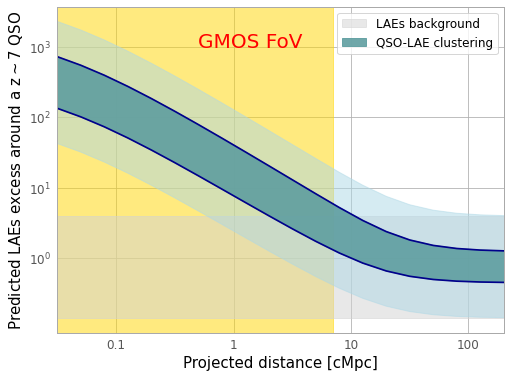

In [9]:
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style

plt.figure(figsize=(8,6))

plt.style.use(astropy_mpl_style)
plt.gca().axvspan(np.log10(0.001), np.log10(14./2.), alpha=0.5, color='gold')
plt.gca().fill_between(lRmax,(lBK_lo-lBK), (lBK_up-lBK), color='lightgray', alpha=0.5, label='LAEs background')
plt.gca().fill_between(lRmax,(lSH_lo-lBK), (lSH_up-lBK), color='lightblue', alpha=0.5)
plt.gca().fill_between(lRmax,(lSH_lo-lBK+0.5), (lSH_up-lBK-0.5), color='cadetblue', alpha=0.9, 
                       label='QSO-LAE clustering')

plt.plot(lRmax,(lSH_lo-lBK+0.5), color='darkblue')
plt.plot(lRmax,(lSH_up-lBK-0.5), color='darkblue')

ly = [0., 1., 2., 3.]
plt.gca().set_yticks(ly)
plt.gca().set_yticklabels(['10$^0$', '10$^1$', '10$^2$', '10$^3$'])

lx = [-1., 0., 1., 2.]
plt.gca().set_xticks(lx)
plt.gca().set_xticklabels(['0.1', '1', '10', '100'])

plt.xlim(-1.5,2.3)
plt.legend()
plt.ylabel('Predicted LAEs excess around a z$\sim$7 QSO', size=15)
plt.xlabel('Projected distance [cMpc]', size=15)
plt.text(-0.3,3,'GMOS FoV', horizontalalignment='left', color='red', size=20)
plt.savefig("clustering.png", bbox_inches="tight")
plt.show()
